# Image size 

Review the MRI brain tumor segmentation dataset

Image: 1231.png, Width: 512, Height: 512


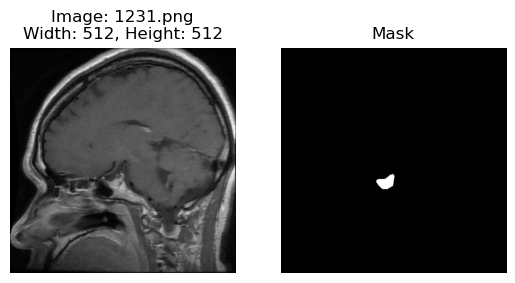

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def get_image_size(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is not None:
        height, width = image.shape[:2]
        return width, height
    else:
        return None

# Replace 'image_folder_path' and 'mask_folder_path' with the actual paths to your image and mask folders on Kaggle
image_folder_path = '/kaggle/input/brain-tumor-segmentation/images'
mask_folder_path = '/kaggle/input/brain-tumor-segmentation/masks'

# List all the files in the image folder
image_files = os.listdir(image_folder_path)

if len(image_files) > 0:
    # Choose one image from the folder (you can change the index if needed)
    image_file = image_files[2]

    # Get the complete path to the image and mask
    image_path = os.path.join(image_folder_path, image_file)
    mask_file = image_file  # Assuming mask file names are the same as image file names
    mask_path = os.path.join(mask_folder_path, mask_file)

    # Get the image size
    image_size = get_image_size(image_path)

    if image_size is not None:
        print(f"Image: {image_file}, Width: {image_size[0]}, Height: {image_size[1]}")

        # Load and plot the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image: {image_file}\nWidth: {image_size[0]}, Height: {image_size[1]}")
        plt.axis('off')

        # Load and plot the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        plt.show()
    else:
        print(f"Failed to read the image: {image_file}")
else:
    print("No images found in the specified folder.")

# U Net model

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [4]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [5]:
# Test the U Net model
def test():
    x = torch.randn((3,1, 256, 256))
    model = UNET(in_channels = 1, out_channels = 1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape
    
if __name__ == "__main__":
    test()

torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])


# Load dataset

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [7]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.mask_paths[index]

        image = Image.open(image_path).convert("RGB")  # Convert to RGB if needed
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask

        if self.transform:
            # Apply any desired transformations (e.g., resizing, normalization, data augmentation)
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [8]:
# Function to create train and test data loaders
def create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths, batch_size=4):
    # Dataset transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize images and masks to 256x256
        transforms.ToTensor(),
    ])

    # Create datasets
    train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=transform)
    val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=transform)  # Validation dataset
    test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)  # No need to shuffle the validation set
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader


In [9]:
# Function to train the UNet model and return the loss values
def train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, early_stopping=None):
    model.train()
    train_loss_values = []
    val_loss_values = []

    best_model_state = None
    best_loss = float('inf')

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Training loop
        for images, masks in train_loader:
            optimizer.zero_grad()

            # Move images and masks to device (GPU if available)
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate and store the average training loss for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        train_loss_values.append(epoch_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}")

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)

                val_running_loss += val_loss.item()

        # Calculate and store the average validation loss for the epoch
        epoch_val_loss = val_running_loss / len(val_loader)
        val_loss_values.append(epoch_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss}")

        if early_stopping is not None:
            early_stopping(epoch_val_loss)
            if early_stopping.stop_training:
                print("Early stopping the training process.")
                break

        # Update best model state if necessary
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_state = model.state_dict()

        model.train()

    return train_loss_values, val_loss_values, best_model_state

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, mode='min'):
        self.patience = patience
        self.mode = mode
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

        if mode == 'min':
            self.best_loss = float('inf')
        elif mode == 'max':
            self.best_loss = float('-inf')
        else:
            raise ValueError("Invalid mode. Use 'min' or 'max'.")

    def __call__(self, current_loss):
        if self.mode == 'min' and current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        elif self.mode == 'max' and current_loss > self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.stop_training = True
            print("Early stopping the training process.")

In [11]:
# Function to save the best model's state to a file
def save_best_model(model_state, filename):
    torch.save(model_state, filename)

In [12]:
import torch
import torch.nn.functional as F

# Function to calculate Intersection over Union (IoU)
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    true_mask = (true_mask > threshold).float()

    intersection = torch.sum(pred_mask * true_mask)
    union = torch.sum((pred_mask + true_mask) > 0)

    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

In [13]:
# Function to visualize images
def visualize_images(image, mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Convert tensors to numpy arrays and remove batch dimension
    image = image.squeeze().permute(1, 2, 0).cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    prediction = prediction.squeeze().cpu().numpy()

    # Visualize original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Visualize mask
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Visualize prediction
    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

# Train and test

Epoch 1/25, Train Loss: 0.08920490194178911
Epoch 1/25, Validation Loss: 0.05801085237558786
Epoch 2/25, Train Loss: 0.04880621786522535
Epoch 2/25, Validation Loss: 0.047051069048511515
Epoch 3/25, Train Loss: 0.041847044331603495
Epoch 3/25, Validation Loss: 0.040127010508017105
Epoch 4/25, Train Loss: 0.03829151136439057
Epoch 4/25, Validation Loss: 0.04630706541530498
Epoch 5/25, Train Loss: 0.03649162423157332
Epoch 5/25, Validation Loss: 0.037606160894229815
Epoch 6/25, Train Loss: 0.034029181797488865
Epoch 6/25, Validation Loss: 0.03502004314213991
Epoch 7/25, Train Loss: 0.03210518610334027
Epoch 7/25, Validation Loss: 0.03413126415681916
Epoch 8/25, Train Loss: 0.029688907791761646
Epoch 8/25, Validation Loss: 0.032494729215448555
Epoch 9/25, Train Loss: 0.02835815366157019
Epoch 9/25, Validation Loss: 0.028136583141885795
Epoch 10/25, Train Loss: 0.026766521695144412
Epoch 10/25, Validation Loss: 0.029677848525151804
Epoch 11/25, Train Loss: 0.024283452364380606
Epoch 11/25,

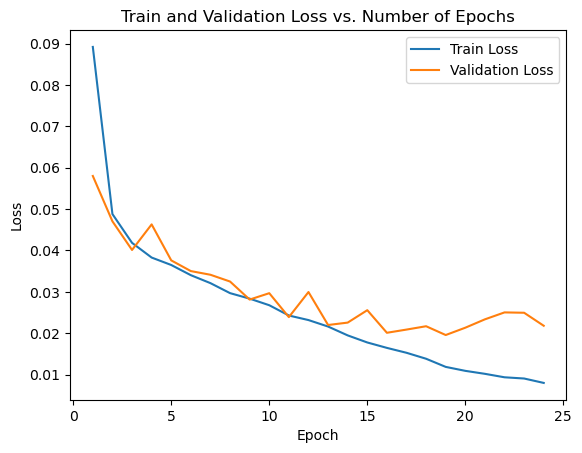

In [17]:
# Example usage:
if __name__ == "__main__":
    image_folder = '/kaggle/input/brain-tumor-segmentation/images'
    mask_folder = '/kaggle/input/brain-tumor-segmentation/masks'
    
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    mask_paths = [os.path.join(mask_folder, mask) for mask in os.listdir(mask_folder)]

    num_samples = len(image_paths)
    train_size = int(0.8 * num_samples)  # 80% for training and validation, 20% for testing
    val_size = (num_samples - train_size) // 2
    indices = np.random.permutation(num_samples)
    train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

    train_image_paths = [image_paths[i] for i in train_indices]
    train_mask_paths = [mask_paths[i] for i in train_indices]
    val_image_paths = [image_paths[i] for i in val_indices]
    val_mask_paths = [mask_paths[i] for i in val_indices]
    test_image_paths = [image_paths[i] for i in test_indices]
    test_mask_paths = [mask_paths[i] for i in test_indices]

    # Initialize the UNet model
    in_channels = 3
    out_channels = 1
    model = UNET(in_channels, out_channels)

    # Move the model to the device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for binary segmentation
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(train_image_paths, train_mask_paths, val_image_paths, val_mask_paths, test_image_paths, test_mask_paths, batch_size=4)
    
    # Initialize the EarlyStopping callback with patience=5 and mode='min'
    early_stopping = EarlyStopping(patience=5, mode='min')

    # Train the model
    num_epochs = 25
    train_loss_values, val_loss_values, best_model_state = train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping)
    
    # Plot the train and valdiation loss vs. the number of epochs
    plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label="Train Loss")
    plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss vs. Number of Epochs")
    plt.legend()
    plt.show()
    
    # Save the best model's state to a file
    if best_model_state is not None:
        save_best_model(best_model_state, "best_model.pth")

Average IoU for the test set: 0.6243


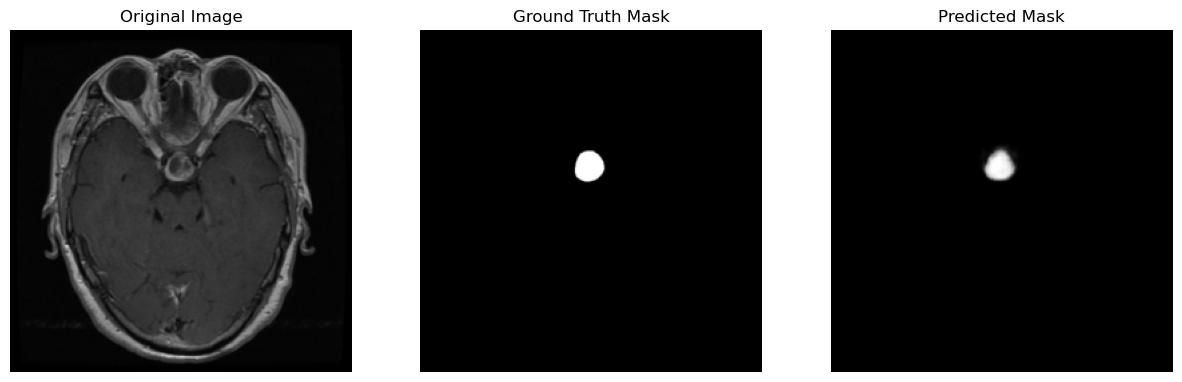

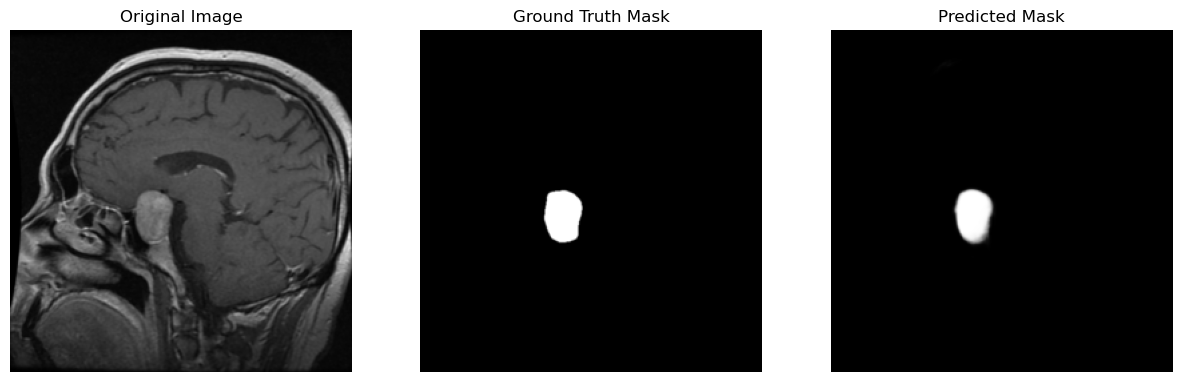

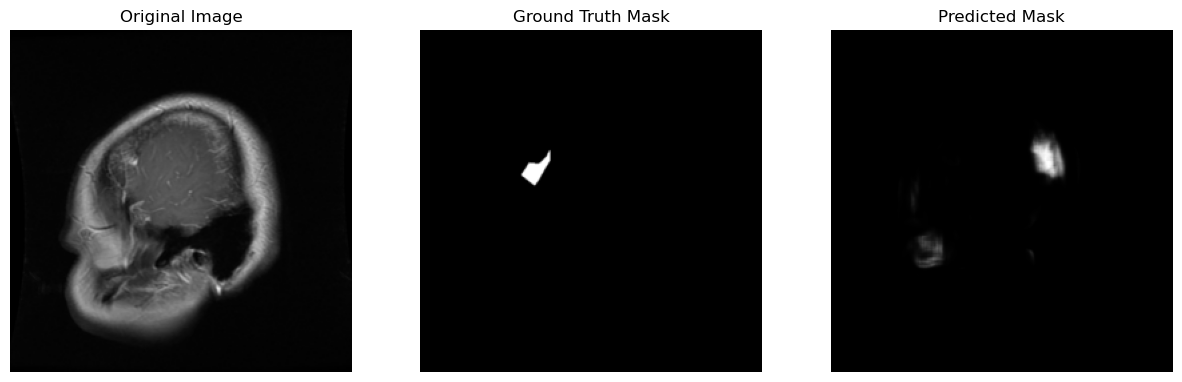

In [18]:
# Test the model and calculate IoU for the test set
iou_scores = []

with torch.no_grad():
    model.eval()
    for images, masks in test_loader:
        # Move images and masks to device (GPU if available)
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions
        predictions = model(images)
        predictions = torch.sigmoid(predictions)

        # Calculate IoU for each batch
        for i in range(len(images)):
            iou = calculate_iou(predictions[i], masks[i])
            iou_scores.append(iou)

# Calculate the average IoU for the entire test set
average_iou = sum(iou_scores) / len(iou_scores)
print(f"Average IoU for the test set: {average_iou:.4f}")

# Visualize some images from the test set
num_images_to_visualize = 3

with torch.no_grad():
    model.eval()
    for i, (image, mask) in enumerate(test_loader):
        if i >= num_images_to_visualize:
            break

        # Move images to device (GPU if available)
        image = image.to(device)

        # Get model predictions
        prediction = model(image)

        # Visualize the images
        visualize_images(image[0], mask[0], torch.sigmoid(prediction)[0])